In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# This method computes the distance between two particles in a cubic box with pbcs
def distance_vector(r_i, r_j, L):
    r_i = np.array((r_i))
    r_j = np.array((r_j))
    dim = len(r_i)
    for i in range(dim):
        d_1D = np.abs(r_i[i]-r_j[i])
        if d_1D > L/2:
            if r_i[i] > r_j[i]:
                r_j[i] += L
            else:
                r_j[i] -= L
    dist = np.linalg.norm(r_i-r_j)
    return dist

# This method computes the force that a particle in position r_j exerts on a particle in r_i
def LJ_force(r_i, r_j, L):
    dist = distance_vector(r_i, r_j, L)
    r_c = 2.5
    F = []
    if dist <= r_c:
        dv_dr = 4*( -12/pow(r_c,13) + 6/pow(r_c,7))
        for i in range(len(r_i)):
            # Analytical form of the cutted-off force
            F.append((4*(12/pow(dist,13)-6/pow(dist,7))+dv_dr)*(r_i[i]-r_j[i])/dist)
    else:
        F= np.array([0.,0.,0.])
    return F

# This method returns the potential energy of two particles in positions r_i and r_j
def LJ_potential(r_i, r_j, L):
    dist = distance_vector(r_i, r_j, L)
    r_c = 2.5
    V_r = 4*(12/pow(dist,12)-6/pow(dist,6))
    V_rc = 4*(12/pow(r_c,12)-6/pow(r_c,6))
    dv_dr = 4*( -12/pow(r_c,13) + 6/pow(r_c,7))
    if dist < r_c:
        V = V_r-V_rc-dv_dr*(dist-r_c)
    else: 
        V = 0
    return V

# This method returns an array containing the total force acting on each particle 
def Forces(r_curr):
    F = np.zeros((N, 3))
    for i in range(N):
        F_i = np.zeros((3))
        for j in range(N):
            if i != j:
                F_i += np.array(LJ_force(r_curr[i], r_curr[j], L))
        F[i] = F_i
    return F

# This method returns a matrix containing the new postitions of the particles after one timestep
# It has a "start" parameter, because the first step of the integration has to be done "manually".
def Verlet_step(r_prev, r_curr, v_start, F, d_t, N, L, start):
    r_next = np.zeros((N, 3))
    # I separate the First step from a generic one
    for i in range(N):
        if start == False:
            r_next[i] = (np.array(r_curr[i])*2 - np.array(r_prev[i]) + pow(d_t,2)*np.array(F[i]))%L
        else:
            r_next[i] = (np.array(r_curr[i]) + d_t*np.array(v_start[i]) + (1/2)*pow(d_t,2)*np.array(F[i]))%L
        # I return the new position and the forces at the previous time
    return r_next

# This method prevents bad initialization to happen
# For instance avoids two particles being "spawned" too close to one another
def initial_state(L,N):
    r_curr = np.random.random((N, 3))*L
    good_start = False
    while good_start == False:
        counter = 0
        for i in range(N):
            for j in range(N):
                if j != i:
                    if distance_vector(r_curr[i],r_curr[j],L) < 1:
                        r_curr[i]=np.random.random(3)*L
                        counter += 1
        if counter == 0:
            good_start = True
    return r_curr

In [2]:
# The following function takes the positions of the particles 
# and returns the head and the linked_list
# n_c is the number of cells per edge of the cubic box. 
# i.e n_c = 5 for a 10x10x10 box with cells having edge length s_c = 2
def linked_cells(r,n_c,L,N):
    s_c = L/n_c #size of a single cell
    c = np.zeros((N+1,3)) # this matrix will classify the positions of the particles on the grid
    head = np.zeros((n_c,n_c,n_c)) # this is an "image" of the grid 
    linked_list = np.zeros(N+1) # this is an efficient "encoder" to find particles belonging to the same cell
    
    # Here i fill the head and linked list 
    for i in range(N):
        c[i+1,:] = np.floor(r[i,:]*(1/s_c)) 
        linked_list[i+1] = head[int(c[i+1,0]),int(c[i+1,1]),int(c[i+1,2])]
        head[int(c[i+1,0]),int(c[i+1,1]),int(c[i+1,2])] = i+1
    return head, linked_list

# This method takes a position on the grid and returns a vector containing the positions of its 3**d neighbours
def nn(i,j,k,n_c):
    x = []
    for a in range(-1,2):
        for b in range(-1,2):
            for c in range(-1,2):
                x.append([(i+a)%n_c,(j+b)%n_c,(k+c)%n_c])
    return x

# This method uses the head and linked_list created using the linked_cell method to compute the forces
def Linked_Forces(r,n_c,L,N):
    s_c = L/n_c
    head, linked_list = linked_cells(r,n_c,L,N)
    # This (rank 3) matrix will contain the forces intercurring between different particles
    # At the end of the particle it will satisfy M[a,b,:]=-M[b,a,:] due to Newton's thid law
    M = np.zeros((N,N,3))
    # I nest three for loops to visit each cell of the grid
    for i in range(len(head)):
        for j in range(len(head)):
            for k in range(len(head)):
                v = []
                w = []
                # x stores the positions of the neighbouring cells of the current cell
                x = nn(i,j,k,n_c)
                # I store, in v=[], all the "names/numbers" of the particles in the neighbourhood of the current cell
                for neigh in range(len(x)):
                    check = False
                    a = head[x[neigh][0]%n_c,x[neigh][1]%n_c,x[neigh][2]%n_c]
                    v.append(a)
                    if [x[neigh][0]%n_c,x[neigh][1]%n_c,x[neigh][2]%n_c] == [i,j,k]:
                        check = True
                        w.append(a)
                    while(a != 0):
                        a = linked_list[int(a)]
                        v.append(a)
                        if [x[neigh][0]%n_c,x[neigh][1]%n_c,x[neigh][2]%n_c] == [i,j,k]:
                            w.append(a)
                    v.pop()
                    if check == True:
                        w.pop()
                # I compute the interaction between each particle in the cell with each particle in the neighbourhood
                # I store the result in the matrix M, using Newton's third law to optimize the computation
                # I also insert an "if" statement to ensure not to compute the same interaction when I will
                # encounter the same couple in future
                for n in range(len(w)):
                    for m in range(len(v)):
                        # This "if" takes only one component into account to check if it has already been computed
                        # I believe it should be fine nonetheless since the probability 
                        # of having a force exactly perpendicular to a specific axis is zero
                        if M[int(w[n])-1,int(v[m])-1,:][0] == 0:
                            w_n = int(w[n])
                            v_m = int(v[m])
                            if w_n%N != v_m%N: # I avoid interaction between a particle and itself
                                Force = np.array(LJ_force(r[w_n-1], r[v_m-1], L))
                                # I use Newton's third law to optimize the computation
                                M[w_n-1,v_m-1,:] = Force
                                M[v_m-1,w_n-1,:]= -1*Force

    # I sum over axis 1 of the matrix M to obtain a matrix F storing the total forces acting on particles
    F = M.sum(axis=1)
    return F

In [12]:
L, N =10, 100;
n_c = 5 # number of cells on one edge of the cubic box
s_c = L/n_c # length of the cell, for n_c = 5 the length of the cell corresponds to 2
d_t = pow(10,-3) # timestep length 

r_x, F_x = [], []
r_y, F_y = [], []
r_z, F_z = [], []

# This is a method that I use to avoid bad initialization. i.e. particles are created too close to each other
r = initial_state(L,N)
#r = np.random.random((N, 3))*L
r_prev = r
r_curr = r
v_start = np.random.random((N, 3))*10 - np.ones((N, 3))*5
F = Linked_Forces(r_curr,n_c,L,N)

r_x.append(r_curr[:,0])
r_y.append(r_curr[:,1])
r_z.append(r_curr[:,2])
F_x.append(F[:,0])
F_y.append(F[:,1])
F_z.append(F[:,2])

start = True
r_curr = Verlet_step(r_prev, r_curr, v_start, F, d_t, N, L, start)

F = Linked_Forces(r_curr,n_c,L,N)
r_x.append(r_curr[:,0])
r_y.append(r_curr[:,1])
r_z.append(r_curr[:,2])
F_x.append(F[:,0])
F_y.append(F[:,1])
F_z.append(F[:,2])

start = False
for i in tqdm(range(1000)):
    temp = r_curr
    r_curr = Verlet_step(r_prev, r_curr, v_start, F, d_t, N, L, start)
    F = Linked_Forces(r_curr,n_c,L,N)
    r_prev = temp
    r_x.append(r_curr[:,0])
    r_y.append(r_curr[:,1])
    r_z.append(r_curr[:,2])
    F_x.append(F[:,0])
    F_y.append(F[:,1])
    F_z.append(F[:,2])

with open('r_x.txt','ab') as f:
        np.savetxt(f, np.array(r_x), fmt="%s")
with open('r_y.txt','ab') as f:
        np.savetxt(f, np.array(r_y), fmt="%s")
with open('r_z.txt','ab') as f:
        np.savetxt(f, np.array(r_z), fmt="%s")
with open('F_x.txt','ab') as f:
        np.savetxt(f, np.array(F_x), fmt="%s")
with open('F_y.txt','ab') as f:
        np.savetxt(f, np.array(F_y), fmt="%s")
with open('F_z.txt','ab') as f:
        np.savetxt(f, np.array(F_z), fmt="%s")




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 2/1000 [00:00<01:20, 12.42it/s]


  0%|          | 3/1000 [00:00<01:26, 11.50it/s]


  0%|          | 4/1000 [00:00<01:32, 10.76it/s]


  1%|          | 6/1000 [00:00<01:31, 10.91it/s]


  1%|          | 8/1000 [00:00<01:30, 10.99it/s]


  1%|          | 9/1000 [00:00<01:34, 10.47it/s]


  1%|          | 10/1000 [00:00<01:46,  9.26it/s]


  1%|          | 11/1000 [00:01<01:49,  9.04it/s]


  1%|▏         | 13/1000 [00:01<01:39,  9.93it/s]


  2%|▏         | 15/1000 [00:01<01:33, 10.56it/s]


  2%|▏         | 17/1000 [00:01<01:32, 10.57it/s]


  2%|▏         | 19/1000 [00:01<01:32, 10.66it/s]


  2%|▏         | 21/1000 [00:01<01:30, 10.84it/s]


  2%|▏         | 23/1000 [00:02<01:28, 11.05it/s]


  2%|▎         | 25/1000 [00:02<01:36, 10.10it/s]


KeyboardInterrupt: 

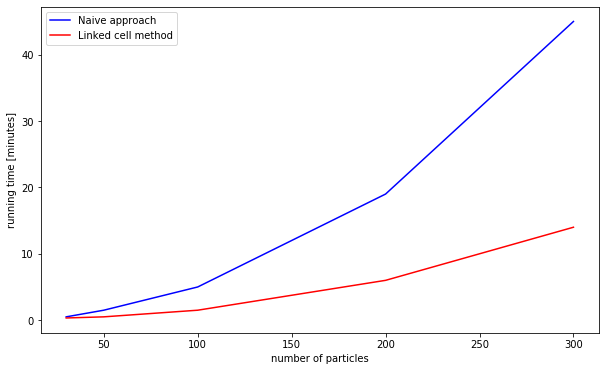

In [13]:
normal = [0.5, 1.5, 5, 19, 45] # Exercise 07 running times
linked = [0.33, 0.5, 1.5, 6, 14] # Exercise 08 running times
particles = [30, 50, 100, 200, 300]

plt.xlabel('number of particles')
plt.ylabel('running time [minutes]')
plt.plot(particles,normal, c='b',label='Naive approach')
plt.plot(particles,linked, c='r',label='Linked cell method')
plt.rcParams['figure.figsize']=[20,12]
plt.legend()
plt.savefig('Runtimes.jpg')
plt.show()

In [18]:
-1%10

9